In [1]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Imports

In [ ]:
!pip install rlcard
!pip install rlcard[torch]
!pip install rlcard[tensorflow]

In [3]:
import torch
import tensorflow
import os

import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import set_global_seed, tournament
from rlcard.utils import Logger

# path
pth = '/content/drive/MyDrive/Colab Notebooks/Thesis'

%cd /content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning

from MLP import *
from models import *

%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn

from DQNAgent_pytorch import DQNAgent

%cd /content/drive/My Drive/Colab Notebooks/Thesis

/content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning
/content/drive/My Drive/Colab Notebooks/Thesis/dqn
/content/drive/My Drive/Colab Notebooks/Thesis


# DQN Models

## all_states_all_actions_2hl_extra_knock_data_40K

### Parameters

In [11]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
dqn_model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 5000  # mahjong_dqn has 100000

# The initial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

In [12]:
torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

MLP_2HL(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=520, bias=True)
  (l3): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)

### Environment Initialization

In [13]:
from tensorflow.keras.backend import clear_session
clear_session()

In [14]:
# Make environment
env = rlcard.make('gin-rummy', config={'seed': 0})
eval_env = rlcard.make('gin-rummy', config={'seed': 0})
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}/{}'.format(state,action,model_name)

# Set a global seed
set_global_seed(0)

agent = DQNAgent(scope='dqn',
                 action_num=env.action_num,
                 replay_memory_init_size=memory_init_size,
                 train_every=train_every,
                 state_shape=env.state_shape,
                 mlp_layers=[520, 520],
                 device=device)
    # def __init__(self,
    #              scope,
    #              replay_memory_size=20000,
    #              replay_memory_init_size=100,
    #              update_target_estimator_every=1000,
    #              discount_factor=0.99,
    #              epsilon_start=1.0,
    #              epsilon_end=0.1,
    #              epsilon_decay_steps=20000,
    #              batch_size=32,
    #              action_num=2,
    #              state_shape=None,
    #              train_every=1,
    #              mlp_layers=None,
    #              learning_rate=0.00005,
    #              device=None)

random_agent = RandomAgent(action_num=eval_env.action_num)
env.set_agents([agent, random_agent])
eval_env.set_agents([agent, random_agent])

# Init a Logger to plot the learning curve
logger = Logger(log_dir)

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [15]:
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

# load pretrained weights
agent.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
agent.q_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
agent.q_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

agent.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
agent.target_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l2.weight)
agent.target_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l2.bias)

In [16]:
agent.q_estimator.qnet.fc_layers

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=260, out_features=520, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=520, out_features=520, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=520, out_features=110, bias=True)
  (6): Softmax(dim=1)
)

### Train


----------------------------------------
  timestep     |  136
  reward       |  0.20679999999999968
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.34822678565979004
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.5819202661514282
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.5173667073249817
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.37212714552879333
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4484, rl-loss: 0.4371311664581299
----------------------------------------
  timestep     |  8940
  reward       |  0.25059999999999966
----------------------------------------
INFO - Agent dqn, step 5000, rl-loss: 0.3787386417388916
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 6000, rl-loss: 0.34643125534057617
INFO - Copied model parameters to target network.
INFO - Agent

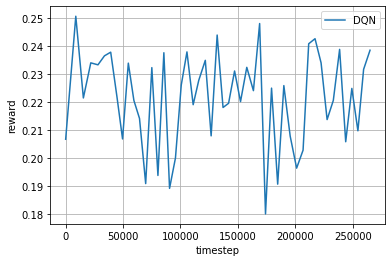

In [17]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}/{}'.format(state,action,dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance. Play with random agents.
    if episode % evaluate_every == 0:
        logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

# Close files in the logger
logger.close_files()

# Plot the learning curve
logger.plot('DQN')

# Save model
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

## all_states_all_actions

### Parameters

In [18]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = 'all_states_all_actions'
dqn_model_name = 'all_states_all_actions'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 5000  # mahjong_dqn has 100000

# The initial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

In [19]:
torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

MLP_base(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)

### Environment Initialization

In [20]:
from tensorflow.keras.backend import clear_session
clear_session()

In [21]:
# Make environment
env = rlcard.make('gin-rummy', config={'seed': 0})
eval_env = rlcard.make('gin-rummy', config={'seed': 0})
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}/{}'.format(state,action,model_name)

# Set a global seed
set_global_seed(0)

agent = DQNAgent(scope='dqn',
                 action_num=env.action_num,
                 replay_memory_init_size=memory_init_size,
                 train_every=train_every,
                 state_shape=env.state_shape,
                 mlp_layers=[520],
                 device=device)
    # def __init__(self,
    #              scope,
    #              replay_memory_size=20000,
    #              replay_memory_init_size=100,
    #              update_target_estimator_every=1000,
    #              discount_factor=0.99,
    #              epsilon_start=1.0,
    #              epsilon_end=0.1,
    #              epsilon_decay_steps=20000,
    #              batch_size=32,
    #              action_num=2,
    #              state_shape=None,
    #              train_every=1,
    #              mlp_layers=None,
    #              learning_rate=0.00005,
    #              device=None)

random_agent = RandomAgent(action_num=eval_env.action_num)
env.set_agents([agent, random_agent])
eval_env.set_agents([agent, random_agent])

# Init a Logger to plot the learning curve
logger = Logger(log_dir)

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [22]:
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

# load pretrained weights
agent.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)

agent.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)

In [23]:
agent.q_estimator.qnet.fc_layers

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=260, out_features=520, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=520, out_features=110, bias=True)
  (4): Softmax(dim=1)
)

### Train


----------------------------------------
  timestep     |  136
  reward       |  0.18599999999999972
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.42462486028671265
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.35666120052337646
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.46394774317741394
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.26728540658950806
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4685, rl-loss: 0.29888513684272766
----------------------------------------
  timestep     |  9347
  reward       |  0.18779999999999977
----------------------------------------
INFO - Agent dqn, step 5000, rl-loss: 0.3649541437625885
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 6000, rl-loss: 0.3121812641620636
INFO - Copied model parameters to target network.
INFO - Age

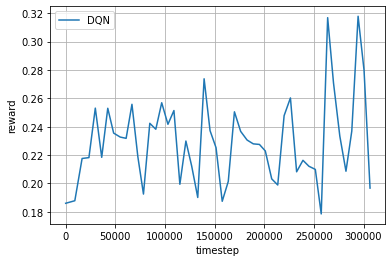

In [24]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}/{}'.format(state,action,dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance. Play with random agents.
    if episode % evaluate_every == 0:
        logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

# Close files in the logger
logger.close_files()

# Plot the learning curve
logger.plot('DQN')

# Save model
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

## bpbd, draw, all_states_all_actions

### Parameters

In [25]:
# Pretrain model selection
state = 'bpbd'
action = 'draw'
model_name = 'all_states_all_actions'
dqn_model_name = 'all_states_all_actions'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 5000  # mahjong_dqn has 100000

# The initial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

In [26]:
torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

MLP(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=110, bias=True)
  (sig): Sigmoid()
)

### Environment Initialization

In [27]:
from tensorflow.keras.backend import clear_session
clear_session()

In [28]:
# Make environment
env = rlcard.make('gin-rummy', config={'seed': 0})
eval_env = rlcard.make('gin-rummy', config={'seed': 0})
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}/{}'.format(state,action,model_name)

# Set a global seed
set_global_seed(0)

agent = DQNAgent(scope='dqn',
                 action_num=env.action_num,
                 replay_memory_init_size=memory_init_size,
                 train_every=train_every,
                 state_shape=env.state_shape,
                 mlp_layers=[520],
                 device=device)
    # def __init__(self,
    #              scope,
    #              replay_memory_size=20000,
    #              replay_memory_init_size=100,
    #              update_target_estimator_every=1000,
    #              discount_factor=0.99,
    #              epsilon_start=1.0,
    #              epsilon_end=0.1,
    #              epsilon_decay_steps=20000,
    #              batch_size=32,
    #              action_num=2,
    #              state_shape=None,
    #              train_every=1,
    #              mlp_layers=None,
    #              learning_rate=0.00005,
    #              device=None)

random_agent = RandomAgent(action_num=eval_env.action_num)
env.set_agents([agent, random_agent])
eval_env.set_agents([agent, random_agent])

# Init a Logger to plot the learning curve
logger = Logger(log_dir)

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [29]:
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

# load pretrained weights
agent.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)

agent.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)

In [30]:
agent.q_estimator.qnet.fc_layers

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=260, out_features=520, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=520, out_features=110, bias=True)
  (4): Softmax(dim=1)
)

### Train


----------------------------------------
  timestep     |  136
  reward       |  -0.33770000000000006
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.6300584673881531
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.7038441896438599
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.5811948180198669
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.5533424615859985
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4805, rl-loss: 0.4326890707015991
----------------------------------------
  timestep     |  9608
  reward       |  -0.3958999999999999
----------------------------------------
INFO - Agent dqn, step 5000, rl-loss: 0.6287760734558105
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 6000, rl-loss: 0.6328587532043457
INFO - Copied model parameters to target network.
INFO - Agent d

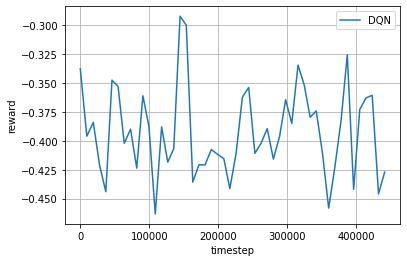

In [31]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}/{}'.format(state,action,dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance. Play with random agents.
    if episode % evaluate_every == 0:
        logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

# Close files in the logger
logger.close_files()

# Plot the learning curve
logger.plot('DQN')

# Save model
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

## apbd, discard, all_states_all_actions

### Parameters

In [32]:
# Pretrain model selection
state = 'apbd'
action = 'discard'
model_name = 'all_states_all_actions'
dqn_model_name = 'all_states_all_actions'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 5000  # mahjong_dqn has 100000

# The initial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

In [33]:
torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

MLP(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=110, bias=True)
  (sig): Sigmoid()
)

### Environment Initialization

In [34]:
from tensorflow.keras.backend import clear_session
clear_session()

In [35]:
# Make environment
env = rlcard.make('gin-rummy', config={'seed': 0})
eval_env = rlcard.make('gin-rummy', config={'seed': 0})
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}/{}'.format(state,action,model_name)

# Set a global seed
set_global_seed(0)

agent = DQNAgent(scope='dqn',
                 action_num=env.action_num,
                 replay_memory_init_size=memory_init_size,
                 train_every=train_every,
                 state_shape=env.state_shape,
                 mlp_layers=[520],
                 device=device)
    # def __init__(self,
    #              scope,
    #              replay_memory_size=20000,
    #              replay_memory_init_size=100,
    #              update_target_estimator_every=1000,
    #              discount_factor=0.99,
    #              epsilon_start=1.0,
    #              epsilon_end=0.1,
    #              epsilon_decay_steps=20000,
    #              batch_size=32,
    #              action_num=2,
    #              state_shape=None,
    #              train_every=1,
    #              mlp_layers=None,
    #              learning_rate=0.00005,
    #              device=None)

random_agent = RandomAgent(action_num=eval_env.action_num)
env.set_agents([agent, random_agent])
eval_env.set_agents([agent, random_agent])

# Init a Logger to plot the learning curve
logger = Logger(log_dir)

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [36]:
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

# load pretrained weights
agent.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)

agent.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)

In [37]:
agent.q_estimator.qnet.fc_layers

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=260, out_features=520, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=520, out_features=110, bias=True)
  (4): Softmax(dim=1)
)

### Train


----------------------------------------
  timestep     |  136
  reward       |  0.1573
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.8197994232177734
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.7358076572418213
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.6394292116165161
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.6357061266899109
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 5000, rl-loss: 0.5975127220153809
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 5573, rl-loss: 0.5555555820465088
----------------------------------------
  timestep     |  11137
  reward       |  0.054899999999999984
----------------------------------------
INFO - Agent dqn, step 6000, rl-loss: 0.5986510515213013
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 700

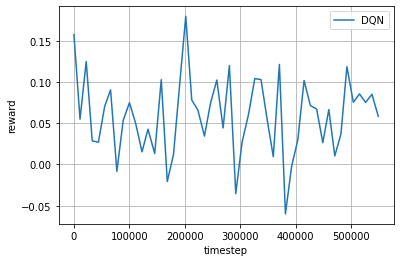

In [38]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}/{}'.format(state,action,dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance. Play with random agents.
    if episode % evaluate_every == 0:
        logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

# Close files in the logger
logger.close_files()

# Plot the learning curve
logger.plot('DQN')

# Save model
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

## apbd, knock, all_states_all_actions

### Parameters

In [39]:
# Pretrain model selection
state = 'apbd'
action = 'knock'
model_name = 'all_states_all_actions'
dqn_model_name = 'all_states_all_actions'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 5000  # mahjong_dqn has 100000

# The initial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

In [40]:
torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

MLP_base(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)

### Environment Initialization

In [41]:
from tensorflow.keras.backend import clear_session
clear_session()

In [42]:
# Make environment
env = rlcard.make('gin-rummy', config={'seed': 0})
eval_env = rlcard.make('gin-rummy', config={'seed': 0})
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}/{}'.format(state,action,model_name)

# Set a global seed
set_global_seed(0)

agent = DQNAgent(scope='dqn',
                 action_num=env.action_num,
                 replay_memory_init_size=memory_init_size,
                 train_every=train_every,
                 state_shape=env.state_shape,
                 mlp_layers=[520],
                 device=device)
    # def __init__(self,
    #              scope,
    #              replay_memory_size=20000,
    #              replay_memory_init_size=100,
    #              update_target_estimator_every=1000,
    #              discount_factor=0.99,
    #              epsilon_start=1.0,
    #              epsilon_end=0.1,
    #              epsilon_decay_steps=20000,
    #              batch_size=32,
    #              action_num=2,
    #              state_shape=None,
    #              train_every=1,
    #              mlp_layers=None,
    #              learning_rate=0.00005,
    #              device=None)

random_agent = RandomAgent(action_num=eval_env.action_num)
env.set_agents([agent, random_agent])
eval_env.set_agents([agent, random_agent])

# Init a Logger to plot the learning curve
logger = Logger(log_dir)

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [43]:
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

# load pretrained weights
agent.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)

agent.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)

In [44]:
agent.q_estimator.qnet.fc_layers

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=260, out_features=520, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=520, out_features=110, bias=True)
  (4): Softmax(dim=1)
)

### Train


----------------------------------------
  timestep     |  136
  reward       |  -0.3342
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.7743442058563232
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.7082974314689636
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.6947224140167236
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.7435239553451538
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 5000, rl-loss: 0.7004126906394958
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 5937, rl-loss: 0.7619070410728455
----------------------------------------
  timestep     |  11871
  reward       |  -0.4170000000000001
----------------------------------------
INFO - Agent dqn, step 6000, rl-loss: 0.7857310771942139
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 700

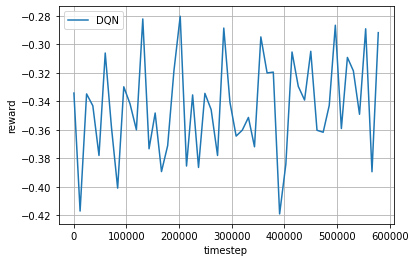

In [45]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}/{}'.format(state,action,dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance. Play with random agents.
    if episode % evaluate_every == 0:
        logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

# Close files in the logger
logger.close_files()

# Plot the learning curve
logger.plot('DQN')

# Save model
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

## baseline

### Parameters

In [46]:
# Pretrain model selection
state = 'base'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 5000  # mahjong_dqn has 100000

# The initial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

### Environment Initialization

In [47]:
from tensorflow.keras.backend import clear_session
clear_session()

In [48]:
# Make environment
env = rlcard.make('gin-rummy', config={'seed': 0})
eval_env = rlcard.make('gin-rummy', config={'seed': 0})
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/base'

# Set a global seed
set_global_seed(0)

agent = DQNAgent(scope='dqn',
                 action_num=env.action_num,
                 replay_memory_init_size=memory_init_size,
                 train_every=train_every,
                 state_shape=env.state_shape,
                 mlp_layers=[520],
                 device=device)
    # def __init__(self,
    #              scope,
    #              replay_memory_size=20000,
    #              replay_memory_init_size=100,
    #              update_target_estimator_every=1000,
    #              discount_factor=0.99,
    #              epsilon_start=1.0,
    #              epsilon_end=0.1,
    #              epsilon_decay_steps=20000,
    #              batch_size=32,
    #              action_num=2,
    #              state_shape=None,
    #              train_every=1,
    #              mlp_layers=None,
    #              learning_rate=0.00005,
    #              device=None)

random_agent = RandomAgent(action_num=eval_env.action_num)
env.set_agents([agent, random_agent])
eval_env.set_agents([agent, random_agent])

# Init a Logger to plot the learning curve
logger = Logger(log_dir)

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Train


----------------------------------------
  timestep     |  136
  reward       |  -0.49010000000000004
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 3.698153523146175e-05
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.0113848140463233
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.03157569840550423
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.0144523736089468
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 5000, rl-loss: 0.012015722692012787
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 6000, rl-loss: 3.218220626877155e-06
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 6146, rl-loss: 0.018052522093057632
----------------------------------------
  timestep     |  12293
  reward       |  -0.5465999999999999
----------------------------------------
IN

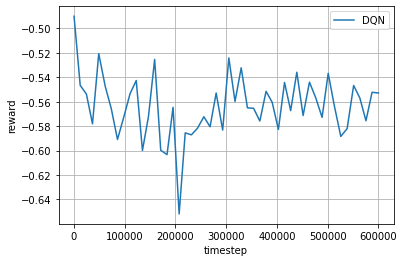

In [49]:
# Save model prior to training
save_dir = 'models/dqn/base'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance. Play with random agents.
    if episode % evaluate_every == 0:
        logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

# Close files in the logger
logger.close_files()

# Plot the learning curve
logger.plot('DQN')

# Save model
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

## all_states_all_actions, Batch Norm

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = 'all_states_all_actions'
dqn_model_name = 'all_states_all_actions_batch_norm'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 5000  # mahjong_dqn has 100000

# The initial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

# Batch Normalization
batch_norm = True

In [ ]:
torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

In [ ]:
# Make environment
env = rlcard.make('gin-rummy', config={'seed': 0})
eval_env = rlcard.make('gin-rummy', config={'seed': 0})
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}/{}'.format(state,action,dqn_model_name)

# Set a global seed
set_global_seed(0)

agent = DQNAgent(scope='dqn',
                 action_num=env.action_num,
                 replay_memory_init_size=memory_init_size,
                 train_every=train_every,
                 state_shape=env.state_shape,
                 mlp_layers=[520],
                 device=device,
                 batch_norm=batch_norm)
    # def __init__(self,
    #              scope,
    #              replay_memory_size=20000,
    #              replay_memory_init_size=100,
    #              update_target_estimator_every=1000,
    #              discount_factor=0.99,
    #              epsilon_start=1.0,
    #              epsilon_end=0.1,
    #              epsilon_decay_steps=20000,
    #              batch_size=32,
    #              action_num=2,
    #              state_shape=None,
    #              train_every=1,
    #              mlp_layers=None,
    #              learning_rate=0.00005,
    #              device=None,
    #              batch_norm=batch_norm)

random_agent = RandomAgent(action_num=eval_env.action_num)
env.set_agents([agent, random_agent])
eval_env.set_agents([agent, random_agent])

# Init a Logger to plot the learning curve
logger = Logger(log_dir)

### Load Pretrained Weights

Apply pretrained weights to the correct layers

In [54]:
agent.q_estimator.qnet.fc_layers

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(260, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=260, out_features=520, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=520, out_features=110, bias=True)
  (5): Softmax(dim=1)
)

In [55]:
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

# load pretrained weights
agent.q_estimator.qnet.fc_layers[2].weight = torch.nn.Parameter(model.l1.weight)
agent.q_estimator.qnet.fc_layers[2].bias = torch.nn.Parameter(model.l1.bias)
agent.q_estimator.qnet.fc_layers[4].weight = torch.nn.Parameter(model.l2.weight)
agent.q_estimator.qnet.fc_layers[4].bias = torch.nn.Parameter(model.l2.bias)

agent.target_estimator.qnet.fc_layers[2].weight = torch.nn.Parameter(model.l1.weight)
agent.target_estimator.qnet.fc_layers[2].bias = torch.nn.Parameter(model.l1.bias)
agent.target_estimator.qnet.fc_layers[4].weight = torch.nn.Parameter(model.l2.weight)
agent.target_estimator.qnet.fc_layers[4].bias = torch.nn.Parameter(model.l2.bias)

### Train


----------------------------------------
  timestep     |  136
  reward       |  0.18599999999999972
----------------------------------------

----------------------------------------
  timestep     |  136
  reward       |  0.18599999999999972
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.6462568640708923
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 1000, rl-loss: 0.6462568640708923
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.4886203706264496
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.4886203706264496
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.6641438603401184
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.6641438603401184
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.7088682055473328
INFO - Copied m

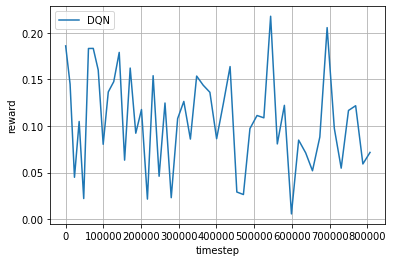

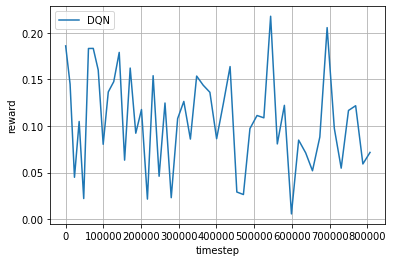


----------------------------------------
  timestep     |  136
  reward       |  0.18599999999999972
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.6462568640708923
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.4886203706264496
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.6641438603401184
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.7088682055473328
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 5000, rl-loss: 0.6000561714172363
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 5922, rl-loss: 0.49826592206954956
----------------------------------------
  timestep     |  11845
  reward       |  0.145
----------------------------------------
INFO - Agent dqn, step 6000, rl-loss: 0.5426924824714661
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 7000

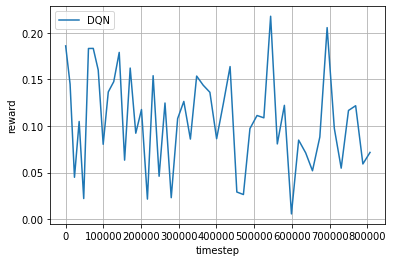


----------------------------------------
  timestep     |  136
  reward       |  0.18599999999999972
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.6462568640708923
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.4886203706264496
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.6641438603401184
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.7088682055473328
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 5000, rl-loss: 0.6000561714172363
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 5922, rl-loss: 0.49826592206954956
----------------------------------------
  timestep     |  11845
  reward       |  0.145
----------------------------------------
INFO - Agent dqn, step 6000, rl-loss: 0.5426924824714661
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 7000

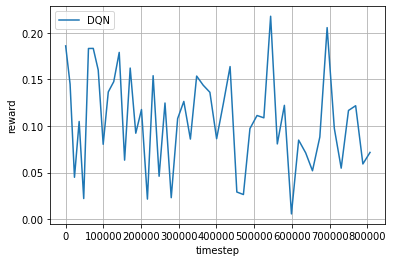


----------------------------------------
  timestep     |  136
  reward       |  0.18599999999999972
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.6462568640708923
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.4886203706264496
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.6641438603401184
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.7088682055473328
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 5000, rl-loss: 0.6000561714172363
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 5922, rl-loss: 0.49826592206954956
----------------------------------------
  timestep     |  11845
  reward       |  0.145
----------------------------------------
INFO - Agent dqn, step 6000, rl-loss: 0.5426924824714661
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 7000

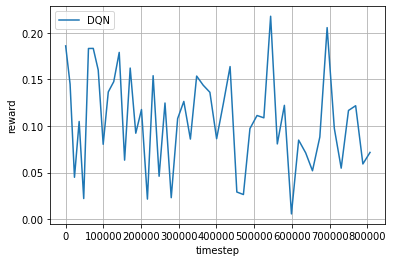

In [56]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}/{}'.format(state,action,dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance. Play with random agents.
    if episode % evaluate_every == 0:
        logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

# Close files in the logger
logger.close_files()

# Plot the learning curve
logger.plot('DQN')

# Save model
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

# Weight Comparison

In [59]:
state = 'all'
action = 'all'
model_name = 'all_states_all_actions'
dqn_model_name = 'all_states_all_actions'
model_dqn_pre = torch.load('models/dqn/{}/{}/{}/model_pretrain.pth'.format(state,action,dqn_model_name), map_location='cpu')
model_dqn_post = torch.load('models/dqn/{}/{}/{}/model_posttrain.pth'.format(state,action,dqn_model_name), map_location='cpu')
model_q_estim_pre = model_dqn_pre['dqn_q_estimator']
model_target_estim_pre = model_dqn_pre['dqn_target_estimator']
model_q_estim_post = model_dqn_post['dqn_q_estimator']
model_target_estim_post = model_dqn_post['dqn_target_estimator']

In [ ]:
# # load pretrained weights
# agent.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
# agent.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
# agent.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
# agent.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)

# agent.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
# agent.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
# agent.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
# agent.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)

In [68]:
weights_q_estim_pre = model_q_estim_pre['fc_layers.1.weight'].flatten().tolist()
weights_target_estim_pre = model_target_estim_pre['fc_layers.1.weight'].flatten().tolist()

In [63]:
weights_q_estim_post = model_q_estim_post['fc_layers.1.weight'].flatten().tolist()
weights_target_estim_post = model_target_estim_post['fc_layers.1.weight'].flatten().tolist()

In [66]:
import matplotlib.pyplot as plt
import numpy as np

In [65]:
dqn_model = 'Q Estimator'
weights_pre = weights_q_estim_pre
weights_post = weights_q_estim_post

In [69]:
dqn_model = 'Target Estimator'
weights_pre = weights_target_estim_pre
weights_post = weights_target_estim_post

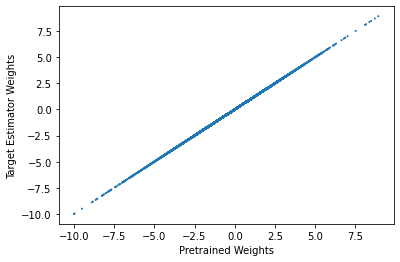

In [70]:
s = np.subtract(weights_post, weights_pre) + 1
plt.scatter(weights_pre, weights_post, s=s)
plt.xlabel('Pretrained Weights')
plt.ylabel('{} Weights'.format(dqn_model))
plt.show()